In [2]:
import os
import pydicom as dicom
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

In [4]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.utils import image_dataset_from_directory

# Loading images

In [5]:
## Example ##

data_path = "/Users/juliaojedaalonso/code/ipl1988/Hemorrhage_detection/raw_data"
sample = dicom.dcmread(os.path.join(data_path, "stage_2_train", "ID_468a4348d.dcm"))

## Convert raw Pixels to Hounsefield Units

In [6]:
## !! The Images may already be in Hounsefield unit, indicated by 0 for intercept and slope?

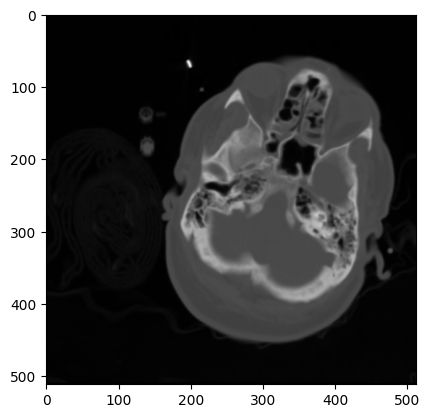

In [7]:
plt.imshow(sample.pixel_array, cmap='grey')

In [8]:
def transform_in_hu(img):
    slope = img.RescaleSlope
    intercept = img.RescaleIntercept
    img = img.pixel_array * slope + intercept
    return img

In [9]:
sample.pixel_array

array([[ 22,  25,  24, ...,  24,  24,  23],
       [ 22,  24,  24, ...,  24,  25,  24],
       [ 21,  22,  24, ...,  25,  23,  21],
       ...,
       [141, 135, 128, ...,  78,  84, 106],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint16)

In [10]:
transformed_sample = transform_in_hu(sample)

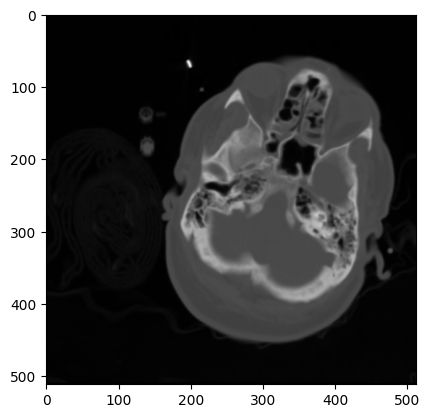

In [11]:
plt.imshow(transformed_sample, cmap='grey')

## Apply Windowing

In [12]:
# Window Settings (unique to the image)
window_center = sample.WindowCenter[0]
window_width = sample.WindowWidth[0]

# Calculate the lower and upper bounds for the window
lower_bound = window_center - (window_width / 2)
upper_bound = window_center + (window_width / 2)

# Apply windowing by clipping to the bounds
windowed_array = np.clip(sample.pixel_array, lower_bound, upper_bound)

In [13]:
def apply_window(img, window_center, window_width):
    
    # If the field is a MultiValue, extract the first element
    if isinstance(window_center, dicom.multival.MultiValue):
        window_center = window_center[0]
    if isinstance(window_width, dicom.multival.MultiValue):
        window_width = window_width[0]
    
    lower_bound = window_center - (window_width / 2)
    upper_bound = window_center + (window_width / 2)
    img = np.clip(img, lower_bound, upper_bound)
    return img

In [14]:
windowed_transformed_sample = apply_window(transformed_sample, sample.WindowCenter, sample.WindowWidth)

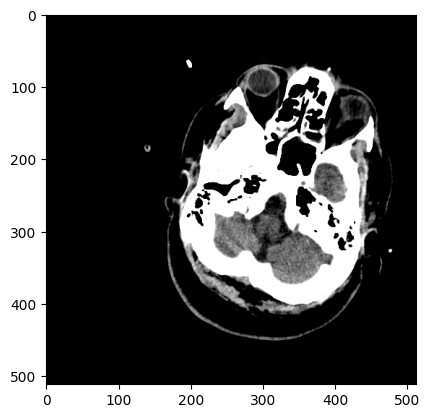

In [15]:
plt.imshow(windowed_transformed_sample, cmap = 'grey')

In [16]:
windowed_array.max()

80.0

## Normalize the windowed image to the range [0, 1]

In [17]:
def normalizer(img):
    minimum = np.min(img)
    maximum = np.max(img)
    img = ((img - minimum ) / (maximum - minimum))
    return img

Recommended Window Settings
Subdural Window:

WL: 50, WW: 130
Balances visibility across various hemorrhages, including subdural, intraparenchymal, and intraventricular types, by enhancing hyperdense features.
Brain Window:

WL: 40, WW: 80
Provides better visualization for gray and white matter, which is useful for detecting subtle changes around subarachnoid hemorrhages.

If you must choose one single window for hemorrhage detection across all types:

**Use the Subdural Window (WL=50, WW=130) as it covers a broader range of densities typical for hemorrhages.**

# Trying to expand the logic to all the files in the folder

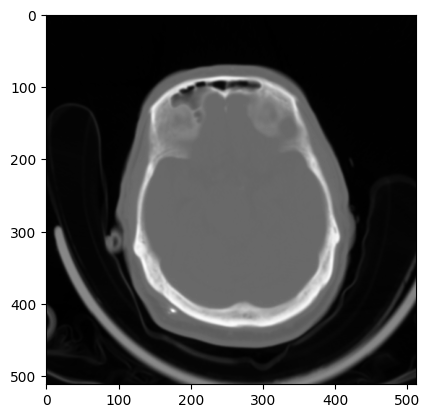

In [18]:
image_path = os.path.join(os.getcwd(), "raw_data", "stage_2_train","ID_e73020990.dcm")
sample = dicom.dcmread(image_path)
plt.imshow(sample.pixel_array, cmap = 'grey');

In [19]:
sample.pixel_array.shape

(512, 512)

In [30]:
import pydicom
import matplotlib.pyplot as plt
import os

# Define the path to the folder containing your DICOM files (relative to the working directory)
folder_path = os.path.join(os.getcwd(), "raw_data", "stage_2_train")
output_path = os.path.join(os.getcwd(), "processed_stage_3_train")

# Ensure the output directory exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Loop through each file in the directory, test the first 10 only!

img_array = []
k = 3992

for filename in os.listdir(folder_path)[0:k]:
    # Check if the file is a DICOM file (assuming .dcm extension)
    if filename.endswith('.dcm'):
        image_path = os.path.join(folder_path, filename)  # Full file path
        img = pydicom.dcmread(image_path)  # Read the DICOM file

    # store temp information needed for the window function
    window_center = img.WindowCenter
    window_width = img.WindowWidth
    
    ## apply HU transformation, returns transformed img
    img = transform_in_hu(img)

    ## apply unique window, returns windowed img
    img = apply_window(img, window_center, window_width)
    
    ## apply normalization, returns min-max-scaled image
    img = normalizer(img) * 255
    img = img.astype(np.uint8)  # Convert to 8-bit unsigned integer

    # Append the processed image to the array
    img_array.append(img)
    # Save as PNG
    output_file = os.path.join(output_path, filename.replace('.dcm', '.png'))
    img_pil = Image.fromarray(img)
    img_pil.save(output_file)

final_array = np.array(img_array)

/var/folders/vm/_dpn604s54z2lrm30_bl1z_80000gn/T/ipykernel_2768/1152598576.py:4: RuntimeWarning: invalid value encountered in divide
  img = ((img - minimum ) / (maximum - minimum))
/var/folders/vm/_dpn604s54z2lrm30_bl1z_80000gn/T/ipykernel_2768/2182140549.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_array = np.array(img_array)


In [31]:
final_array.shape

(3992,)

# Taking Care of the Target values

## Load target data

In [32]:
data_path = "/Users/juliaojedaalonso/code/ipl1988/Hemorrhage_detection/raw_data"

In [33]:
data_path

'/Users/juliaojedaalonso/code/ipl1988/Hemorrhage_detection/raw_data'

In [34]:
df = pd.read_csv(os.path.join(data_path, "stage_2_train.csv"))

In [35]:
df

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0
...,...,...
4516837,ID_4a85a3a3f_intraparenchymal,0
4516838,ID_4a85a3a3f_intraventricular,0
4516839,ID_4a85a3a3f_subarachnoid,0
4516840,ID_4a85a3a3f_subdural,0


## Extract the Image ID
Assuming the ID column contains both the image ID (e.g., ID_12cadc6af) and the type of hemorrhage (e.g., epidural, intraparenchymal), we need to extract just the base ID. The base ID is the part before the first underscore. This can be done using the str.extract() method to grab everything up to the first underscore:

In [36]:
df['base_ID'] = df['ID'].str.extract(r'^(ID_[^_]+)')

In [37]:
df

,ID,Label,base_ID
0,ID_12cadc6af_epidural,0,ID_12cadc6af
1,ID_12cadc6af_intraparenchymal,0,ID_12cadc6af
2,ID_12cadc6af_intraventricular,0,ID_12cadc6af
3,ID_12cadc6af_subarachnoid,0,ID_12cadc6af
4,ID_12cadc6af_subdural,0,ID_12cadc6af
...,...,...,...
4516837,ID_4a85a3a3f_intraparenchymal,0,ID_4a85a3a3f
4516838,ID_4a85a3a3f_intraventricular,0,ID_4a85a3a3f
4516839,ID_4a85a3a3f_subarachnoid,0,ID_4a85a3a3f
4516840,ID_4a85a3a3f_subdural,0,ID_4a85a3a3f


## Group the Labels by the Base Image ID
Now, we can group the DataFrame by this base ID and collect all the corresponding Label values for each unique ID. We will use groupby() and apply(list) to create a list of labels for each image:

In [38]:
grouped_data = df.groupby('base_ID')['Label'].apply(list).to_dict()

In [39]:
len(grouped_data)

752803

## Resulting Dictionary Structure
The resulting grouped_data will be a dictionary where the keys are the base image IDs and the values are lists of the labels corresponding to that image ID:

In [40]:
listi = [label + '.png' for label in df['base_ID']]
listi
len(listi)

4516842

In [41]:
temp = [grouped_data[file.split('.')[0]][-1] for file in listi]
len(temp)

4516842

In [42]:
test = temp

### Extract the any_label for every ID ###

In [43]:
import os

raw_img_list = [f for f in os.listdir("/Users/juliaojedaalonso/code/ipl1988/Hemorrhage_detection/processed_stage_3_train/processed_stage_2_train") if f.endswith(('.jpg', '.png'))]

In [44]:

raw_img_list

['ID_7f335baa0.png',
 'ID_3ca5ed390.png',
 'ID_d0b395b26.png',
 'ID_09523a0ef.png',
 'ID_2121a8b31.png',
 'ID_ebe5a9be2.png',
 'ID_662684b7d.png',
 'ID_064ed292c.png',
 'ID_4e5c86fd7.png',
 'ID_ce7b93c85.png',
 'ID_a19d4af14.png',
 'ID_47a77a8c0.png',
 'ID_d467aa73e.png',
 'ID_021c63d1b.png',
 'ID_4faecfe50.png',
 'ID_cd324e00c.png',
 'ID_c6a2d64df.png',
 'ID_7d5269f26.png',
 'ID_8bd7c0b9a.png',
 'ID_cf5e7ca00.png',
 'ID_5684db3bf.png',
 'ID_32586c443.png',
 'ID_a82e70424.png',
 'ID_55a532705.png',
 'ID_cfb739b92.png',
 'ID_dfa84d624.png',
 'ID_865dd7c5a.png',
 'ID_75e1787e8.png',
 'ID_217efdc18.png',
 'ID_f8f14ea44.png',
 'ID_3b56a6814.png',
 'ID_7e27e9831.png',
 'ID_6efdb00ab.png',
 'ID_935b75c01.png',
 'ID_e9462d638.png',
 'ID_0e6fad1c3.png',
 'ID_ac3496d04.png',
 'ID_94f4b4dc8.png',
 'ID_25a15014c.png',
 'ID_7e28c0939.png',
 'ID_4f8880987.png',
 'ID_8bb28c830.png',
 'ID_ae8317a70.png',
 'ID_fc984469c.png',
 'ID_5164bcbed.png',
 'ID_22e0718f5.png',
 'ID_31a916345.png',
 'ID_5824f110

In [45]:
len(raw_img_list)

3992

In [46]:
labels=[]

for filename in raw_img_list:
    value = grouped_data[filename[:-4]]
    labels.append(value[-1])

In [47]:
labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,


### Cross-Check if the labels correspond correctly (examples)##

In [36]:
# For File ID_718b3aa9c #

#file_to_check = "ID_718b3aa9c"

In [37]:
# # What index does this file have in the raw_img_list? #
# index_no = raw_img_list.index(file_to_check + '.dcm')
# index_no

ValueError: 'ID_718b3aa9c.dcm' is not in list

In [ ]:
# # What label is assigned to this index in the labels?#
# labels[index_no]

In [ ]:
# # Is the label equal to the label in the original df ? #
# df[df['base_ID'] == file_to_check]

# Dataset for tensorflow

In [48]:
## Specify the path to your target CSV file
data_path = "/Users/juliaojedaalonso/code/ipl1988/Hemorrhage_detection/raw_data"
# Read the target CSV file
#df = pd.read_csv(os.path.join(data_path, "stage_2_train.csv"))
#df

In [49]:
# Location of our data in 2 variables to re use later
train_data_dir = '/Users/juliaojedaalonso/code/ipl1988/Hemorrhage_detection/processed_stage_3_train/'
#test_data_dir = 'hem_detection_labels/test_set/'

In [50]:
os.listdir(train_data_dir)

['ID_7f335baa0.png',
 'ID_3ca5ed390.png',
 'ID_d0b395b26.png',
 'ID_09523a0ef.png',
 'ID_2121a8b31.png',
 'ID_ebe5a9be2.png',
 'ID_662684b7d.png',
 'ID_064ed292c.png',
 'ID_4e5c86fd7.png',
 'ID_ce7b93c85.png',
 'ID_a19d4af14.png',
 'ID_47a77a8c0.png',
 'ID_d467aa73e.png',
 'ID_021c63d1b.png',
 'ID_4faecfe50.png',
 'ID_cd324e00c.png',
 'ID_c6a2d64df.png',
 'ID_7d5269f26.png',
 'ID_8bd7c0b9a.png',
 'ID_cf5e7ca00.png',
 'ID_5684db3bf.png',
 'ID_32586c443.png',
 'ID_a82e70424.png',
 'ID_55a532705.png',
 'ID_cfb739b92.png',
 'ID_dfa84d624.png',
 'ID_865dd7c5a.png',
 'ID_75e1787e8.png',
 'ID_217efdc18.png',
 'ID_f8f14ea44.png',
 'ID_3b56a6814.png',
 'ID_7e27e9831.png',
 'ID_6efdb00ab.png',
 'ID_935b75c01.png',
 'ID_e9462d638.png',
 'ID_0e6fad1c3.png',
 'ID_ac3496d04.png',
 'ID_94f4b4dc8.png',
 'ID_25a15014c.png',
 'ID_7e28c0939.png',
 'ID_4f8880987.png',
 'ID_8bb28c830.png',
 'ID_ae8317a70.png',
 'ID_fc984469c.png',
 'ID_5164bcbed.png',
 'ID_22e0718f5.png',
 'ID_31a916345.png',
 'ID_5824f110

In [51]:

#Training data location
train_ds, val_ds = image_dataset_from_directory(
    directory = train_data_dir,
    subset='both',
    labels=labels,
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    seed='None',
    image_size=(512,512),
    shuffle=False,
    batch_size=32,
    validation_split=0.2,
    
)

# val_ds = image_dataset_from_directory(
#     directory = train_data_dir,
#     validation_split=0.2,
#     subset='validation',
#     labels=labels,
#     label_mode='int',
#     seed='None',
#     image_size=(512,512),
#     batch_size=32
# )


Found 3992 files belonging to 1 classes.
Using 3194 files for training.
Using 798 files for validation.


In [52]:
class_names = train_ds.class_names
print(class_names)

['processed_stage_2_train']


# Windowing and normalization - Brain tissue

In [53]:
windowed_transformed_sample = apply_window(transformed_sample, sample.WindowCenter, sample.WindowWidth)

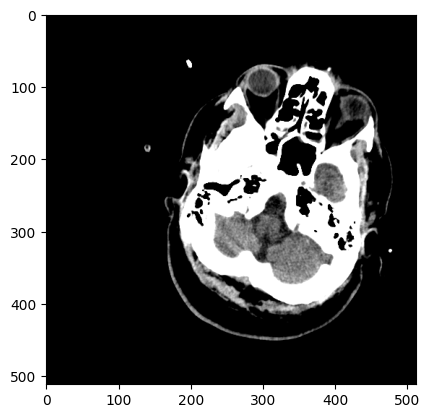

In [54]:
plt.imshow(windowed_transformed_sample, cmap = 'grey')

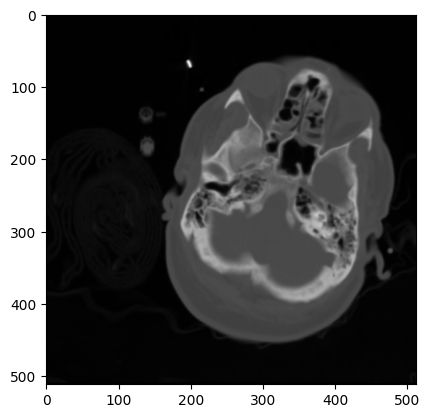

In [56]:
plt.imshow(normalizer(transformed_sample), cmap = 'grey')

In [57]:
# Window Settings (unique to the image)
window_center = sample.WindowCenter[0]
window_width = sample.WindowWidth[0]

# Calculate the lower and upper bounds for the window
lower_bound = window_center - (window_width / 2)
upper_bound = window_center + (window_width / 2)

# Apply windowing by clipping to the bounds
windowed_array = np.clip(sample.pixel_array, lower_bound, upper_bound)

In [58]:
def apply_window(img, window_center, window_width):
    
    # If the field is a MultiValue, extract the first element
    if isinstance(window_center, dicom.multival.MultiValue):
        window_center = window_center[0]
    if isinstance(window_width, dicom.multival.MultiValue):
        window_width = window_width[0]
    
    lower_bound = window_center - (window_width / 2)
    upper_bound = window_center + (window_width / 2)
    img = np.clip(img, lower_bound, upper_bound)
    return img

# Architecture

In [59]:
# Intialize the Sequential model --> Linear stack of layers
model = Sequential()

# Data Augmentation Layers

model.add(layers.RandomFlip("horizontal"))
model.add(layers.RandomZoom(0.1))
model.add(layers.RandomTranslation(0.2, 0.2))
model.add(layers.RandomRotation(0.1))


# Add Convolutional Layer
model.add(Conv2D(32,(5,5),activation='relu', input_shape=(512,512,1)))

# Add Pooling Layer --> MaxPooling for down-sampling while retaining dominant features
model.add(MaxPooling2D(pool_size=(2,2)))

# Add another Convolutional Layer
model.add(Conv2D(64,(5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Add another Convolutional Layer
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# # Add another Convolutional Layer
# model.add(Conv2D(256,(5,5), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))


# Flatten the feature maps to feed into Dense layers
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(512, activation='relu')) # Hidden dense layer
model.add(Dropout(0.5)) # Dropout to prevent overfitting
model.add(Dense(1, activation='sigmoid')) # Output layer for 6-class classification



In [60]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])

#Summary of the model

In [61]:
from tensorflow.keras import callbacks
MODEL = "model"

# modelCheckpoint = callbacks.ModelCheckpoint(MODEL,
#                                            monitor='val_loss',
#                                            verbose=0,
#                                            save_best_only=True)

# LRreducer = callbacks.ReduceLROnPlateau(monitor='val_loss',
#                                        factor=0.1,
#                                        patience=3,
#                                        verbose=1,
#                                        min_lr=0)

early_stopping = callbacks.EarlyStopping(monitor='accuracy',
                                      patience=10,
                                      verbose=0,
                                      restore_best_weights=True)

In [64]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
100/100 [==============================] - 240s 2s/step - loss: 3.0210 - accuracy: 0.8121 - auc: 0.5032 - val_loss: 0.5343 - val_accuracy: 0.8559 - val_auc: 0.4672
Epoch 2/30
100/100 [==============================] - 243s 2s/step - loss: 0.4660 - accuracy: 0.8475 - auc: 0.5067 - val_loss: 0.5122 - val_accuracy: 0.8559 - val_auc: 0.4797
Epoch 3/30
100/100 [==============================] - 241s 2s/step - loss: 0.4671 - accuracy: 0.8475 - auc: 0.4895 - val_loss: 0.5064 - val_accuracy: 0.8559 - val_auc: 0.4613
Epoch 4/30
100/100 [==============================] - 242s 2s/step - loss: 0.4520 - accuracy: 0.8475 - auc: 0.4988 - val_loss: 0.4379 - val_accuracy: 0.8559 - val_auc: 0.4656
Epoch 5/30
100/100 [==============================] - 240s 2s/step - loss: 0.4406 - accuracy: 0.8475 - auc: 0.5124 - val_loss: 0.4362 - val_accuracy: 0.8559 - val_auc: 0.4632
Epoch 6/30
100/100 [==============================] - 241s 2s/step - loss: 0.4339 - accuracy: 0.8475 - auc: 0.5096 - val_loss

In [ ]:
#Train the Model

# history = model.fit(
#     train_ds,
#     epochs=30,
#     callbacks=[EarlyStopper]
#     )

In [65]:
#Plot accuracy
history.history

{'loss': [3.021000623703003,
  0.4659801721572876,
  0.4671126902103424,
  0.45199593901634216,
  0.4406190514564514,
  0.43385955691337585,
  0.42977476119995117,
  0.4295671880245209,
  0.4305260181427002,
  0.4275461733341217,
  0.42857858538627625,
  0.4283873438835144],
 'accuracy': [0.8121477961540222,
  0.8475266098976135,
  0.8475266098976135,
  0.8475266098976135,
  0.8475266098976135,
  0.8475266098976135,
  0.8475266098976135,
  0.8475266098976135,
  0.8475266098976135,
  0.8475266098976135,
  0.8475266098976135,
  0.8475266098976135],
 'auc': [0.503185510635376,
  0.5067207217216492,
  0.48951610922813416,
  0.49880075454711914,
  0.5124280452728271,
  0.5095853805541992,
  0.514385461807251,
  0.5087680816650391,
  0.49023786187171936,
  0.5109276175498962,
  0.5028961300849915,
  0.49744749069213867],
 'val_loss': [0.5343332290649414,
  0.512243390083313,
  0.506434440612793,
  0.43794745206832886,
  0.43621882796287537,
  0.42438551783561707,
  0.424079567193985,
  0.421

# Save and use the model

In [66]:

model.save("model.h5")

In [67]:
from tensorflow.keras.models import load_model
model_v2 = load_model("model.h5")